In [3]:
import sys
sys.path.insert(0, '..')

In [4]:
from scipy.io import loadmat
from os.path import basename
import numpy as np
from scipy import ndimage

In [5]:


def getLarea(input_mask):
    try:
        labeled_mask, cc_num = ndimage.label(input_mask)
        mask = (labeled_mask == (np.bincount(labeled_mask.flat)[1:].argmax() + 1))
    except:
        mask = input_mask
    return mask

def getkvgh(matfile):
    mat = loadmat(matfile)
    BMAstr = basename(matfile).split('.')[0][-1]
    T1map = mat['%s_T1map_pre' % BMAstr]
    imapre = mat['%s_im_pre' % BMAstr]
    LVb = mat['%s_inner' % BMAstr]
    LVw = mat['%s_LV_wall_non' % BMAstr]
    RVb = mat['%s_heart' % BMAstr] & np.logical_not(mat['%s_outer' % BMAstr])
    RVb = getLarea(RVb)
    labelimg = (LVb*0).astype(np.uint16)
    labelimg[np.nonzero(LVb)] = 3
    labelimg[np.nonzero(LVw)] = 2
    labelimg[np.nonzero(RVb)] = 1
    omatsize = T1map.shape
    return T1map, imapre, labelimg, omatsize

In [6]:
T1map, imapre, labelimg, omatsize = getkvgh(r'C:\TudoCD\T-995835-20151229_B.mat')
lvb = labelimg
LVbmask = (lvb==3)
LVwmask = (lvb==2)
RVbmask = (lvb==1)


[12.46666667 15.91044776 19.44117647 12.2        12.04477612 12.42647059]


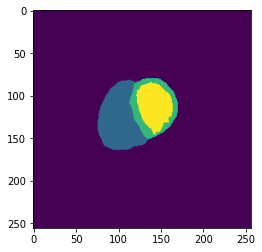

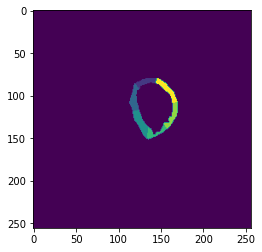

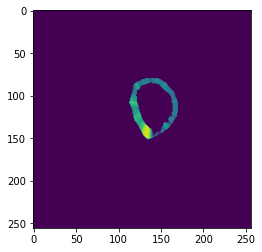

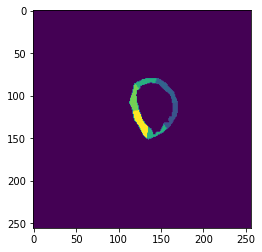

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from pymr.heart import ahaseg
heart_mask = (LVbmask, LVwmask, RVbmask)
label_mask = ahaseg.get_seg(heart_mask, nseg=6)
thickmap = ahaseg.get_thickmap(LVwmask)
thick = ahaseg.get_thick(heart_mask, nseg=6)
thickmap_mean = ahaseg.get_thickmap_mean(label_mask, thick)


%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(labelimg)
plt.figure()
plt.imshow(label_mask)
plt.figure()
plt.imshow(thickmap)
plt.figure()
plt.imshow(thickmap_mean)
print(thick)

In [13]:
from scipy import ndimage

for ii in range(np.max(label_mask)):
    center = ndimage.center_of_mass(label_mask==ii)
    print(center)

(127.7536637294668, 127.2834164762926)
(83.97297297297297, 131.86486486486487)
(103.93981481481481, 118.54166666666667)
(131.93984962406014, 126.06015037593986)
(143.34459459459458, 142.89864864864865)
(123.39896373056995, 163.2538860103627)


In [11]:
LV_center

(83.97297297297297, 131.86486486486487)

In [14]:
import nibabel

In [17]:
heart = nibabel.load(r"C:\TudoCD\OpenDataset2\A0S9V9\A0S9V9_sa_gt.nii.gz").get_fdata()

In [18]:
heart.shape

(216, 256, 13, 25)

In [109]:
diastole, systole = np.sum(heart, axis=(0, 1, 2)).argsort()[::-1][[0,1]]

In [119]:
#step 1: collect dia_frame and sys_frame
curve = np.sum(heart, axis=(0, 1, 2))
dia_frame = np.argmax(curve)
curve[curve==0] = 1e20
sys_frame = np.argmin(curve)

#step 2: 


In [234]:
def get_slice_label(heart4d):
    heart = heart4d.copy()
    curve3 = np.sum(heart==3, axis=(0, 1, 3))
    curve2 = np.sum(heart==2, axis=(0, 1, 3))
    curve1 = np.sum(heart==1, axis=(0, 1, 3))

    curve_and = (curve3 > 0) & (curve2 > 0) & (curve1 > 0)
    curve_or = (curve3 > 0) | (curve2 > 0) | (curve1 > 0)
    curve_and = curve_and.astype(np.int)
    curve_or = curve_or.astype(np.int)
    curve_diff = curve_or-curve_and
    slice_label = curve_and * 0
    curve_apex = curve_diff.copy()
    curve_apex[:curve_apex.size//2] = 0
    curve_basal = curve_diff.copy()
    curve_basal[curve_apex.size//2:] = 0
    #curve_apex = curve_apex * 4
    
    loc = dict()
    if np.sum(curve_apex) > 0:
        #got_apex = True    
        loc[3] = [1]*1 + [2]*1 + [3]*1
        loc[4] = [1]*1 + [2]*2 + [3]*1
        loc[5] = [1]*2 + [2]*2 + [3]*1
        loc[6] = [1]*2 + [2]*2 + [3]*2
        loc[7] = [1]*2 + [2]*3 + [3]*2
        loc[8] = [1]*3 + [2]*3 + [3]*2
        loc[9] = [1]*3 + [2]*3 + [3]*3
        loc[10] = [1]*3 + [2]*4 + [3]*3
        loc[11] = [1]*4 + [2]*4 + [3]*3
        loc[12] = [1]*4 + [2]*4 + [3]*4
        loc[13] = [1]*4 + [2]*5 + [3]*4
        loc[14] = [1]*5 + [2]*5 + [3]*4
        loc[15] = [1]*5 + [2]*5 + [3]*5
    else:
        loc[3] = [1]*1 + [2]*1 + [3]*1
        loc[4] = [1]*1 + [2]*1 + [3]*1 + [4]*1
        loc[5] = [1]*1 + [2]*2 + [3]*1 + [4]*1
        loc[6] = [1]*2 + [2]*2 + [3]*1 + [4]*1
        loc[7] = [1]*2 + [2]*2 + [3]*2 + [4]*1
        loc[8] = [1]*2 + [2]*3 + [3]*2 + [4]*1
        loc[9] = [1]*3 + [2]*3 + [3]*2 + [4]*1
        loc[10] = [1]*3 + [2]*3 + [3]*3 + [4]*1
        loc[11] = [1]*3 + [2]*3 + [3]*3 + [4]*2
        loc[12] = [1]*3 + [2]*4 + [3]*3 + [4]*2
        loc[13] = [1]*4 + [2]*4 + [3]*3 + [4]*2
        loc[14] = [1]*4 + [2]*4 + [3]*4 + [4]*2
        loc[15] = [1]*4 + [2]*4 + [3]*4 + [4]*3
        
    slice_label[curve_and > 0] = loc[np.sum(curve_and)]
    slice_label[curve_apex > 0] = 4
    slice_label[curve_basal > 0] = 5
    return slice_label


In [260]:
slice_label = get_slice_label(heart)
print(slice_label)
offset = dict()
offset[1] = 0
offset[2] = 6
offset[3] = 12

count = -1
heart_aha17_4d = heart  * 0
for ii in range(slice_label.size):
    #print(slice_label[ii])
    count = count + 1
    if (slice_label[ii] == 0) or (slice_label[ii] == 5):
        continue
        
    if slice_label[ii] == 4:
        temp = heart[:, :, ii, :].copy()
        temp[temp==2] = 17
        temp[temp==1] = 0
        temp[temp==3] = 0
        heart_aha17_4d[:, :, ii, :] = temp
        

    heart_xyt = heart[:, :, ii, :].copy()
    
    curve = np.sum(heart_xyt, axis=(0, 1))
    dia_frame = np.argmax(curve)
    curve[curve==0] = 1e20
    sys_frame = np.argmin(curve)
    #print(dia_frame, sys_frame)
    heart_xy_dia = heart_xyt[..., dia_frame]
    heart_xy_sys = heart_xyt[..., sys_frame]
    if slice_label[ii] == 3:
        nseg = 4
    else:
        nseg = 6
    
    if (np.sum(heart_xy_dia==3)) == 0 or (np.sum(heart_xy_sys==3) == 0):
        slice_label[ii] = 5
        continue
        
        
    dia_seg = ahaseg.get_seg((heart_xy_dia==1, heart_xy_dia==2, heart_xy_dia==3), nseg)
    sys_seg = ahaseg.get_seg((heart_xy_sys==1, heart_xy_sys==2, heart_xy_sys==3), nseg)
    
    dia_seg[dia_seg > 0] = dia_seg[dia_seg > 0] + offset[slice_label[ii]]
    sys_seg[sys_seg > 0] = sys_seg[sys_seg > 0] + offset[slice_label[ii]]
    
    heart_aha17_4d[:, :, ii, dia_frame] = dia_seg
    heart_aha17_4d[:, :, ii, sys_frame] = sys_seg


[0 0 5 1 1 1 2 2 2 3 3 4 4]


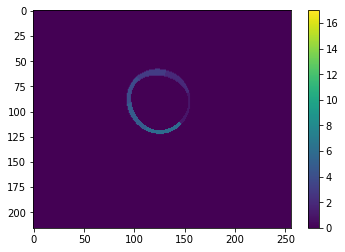

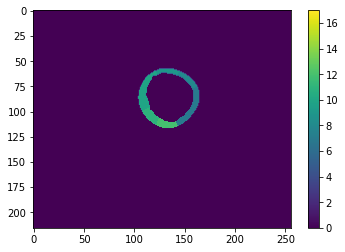

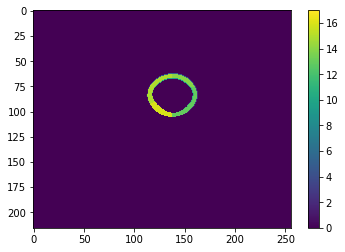

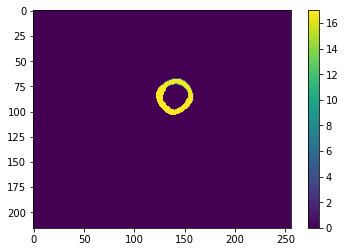

In [263]:
plt.figure()
plt.imshow(heart_aha17_4d[:, :, 5, dia_frame], vmin=0, vmax=17)
plt.colorbar()
plt.figure()
plt.imshow(heart_aha17_4d[:, :, 8, dia_frame], vmin=0, vmax=17)
plt.colorbar()
plt.figure()
plt.imshow(heart_aha17_4d[:, :, 10, dia_frame], vmin=0, vmax=17)
plt.colorbar()

plt.figure()
plt.imshow(heart_aha17_4d[:, :, 11, dia_frame], vmin=0, vmax=17)
plt.colorbar()

In [223]:
slice_label[curve_and > 0] = loc[np.sum(curve_and)]
slice_label[curve_apex > 0] = 4
slice_label[curve_basal > 0] = 5

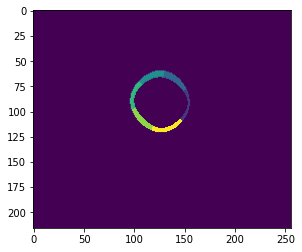

In [138]:
heart_mask = heart[..., 5, systole]
LVbmask = (heart_mask==1)
LVwmask = (heart_mask==2)
RVbmask = (heart_mask==3)
heart_mask = (LVbmask, LVwmask, RVbmask)
heart_seg_sys = ahaseg.get_seg(heart_mask, nseg=6)
plt.imshow(heart_seg_sys)

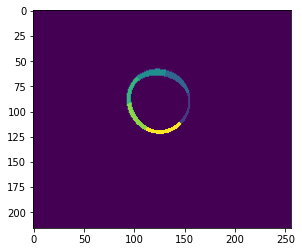

In [112]:
heart_mask = heart[..., 5, diastole]
LVbmask = (heart_mask==1)
LVwmask = (heart_mask==2)
RVbmask = (heart_mask==3)
heart_mask = (LVbmask, LVwmask, RVbmask)
heart_seg_dia = ahaseg.get_seg(heart_mask, nseg=6)
plt.imshow(heart_seg_dia)

In [105]:
def get_center(label_mask):
    center_list = []
    for ii in range(np.max(label_mask)):
        center = ndimage.center_of_mass(label_mask==(ii+1))
        center_list.append(center)
        
    return np.array(center_list)

In [106]:
sys6 = get_center(heart_seg_sys)
dia6 = get_center(heart_seg_dia)

In [107]:
vector = (sys6 - dia6)

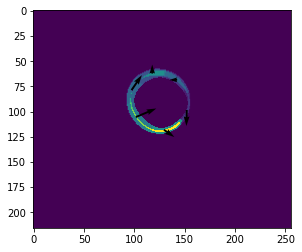

In [108]:
plt.imshow(heart_seg_dia + heart_seg_sys)
plt.quiver(dia6[:, 1], dia6[:, 0] , vector[:, 1], vector[:, 0])
#plt.scatter(dia6[:, 1], dia6[:, 0])
#plt.ylim(0, heart_seg_sys.shape[1])
#plt.xlim(0, heart_seg_sys.shape[0])

In [102]:
vector

array([[-3.74476723, -1.47743017],
       [-1.35581491, -4.50864046],
       [ 2.0857017 ,  0.02737387],
       [ 4.42333563,  4.75919132],
       [ 1.00854655,  8.78401039],
       [-2.71679136,  2.36420102]])

In [63]:
vector

array([[ 7.31248456e-03,  2.40871366e-02],
       [ 3.74476723e+00,  1.47743017e+00],
       [ 1.35581491e+00,  4.50864046e+00],
       [-2.08570170e+00, -2.73738709e-02],
       [-4.42333563e+00, -4.75919132e+00],
       [-1.00854655e+00, -8.78401039e+00]])

In [64]:
dia6[:,0]

array([107.80171223,  96.28666667,  72.07878788,  66.50980392,
        84.27891156, 113.85611511])